# DIABETES PROGRESSION

### 1 INTRODUCTION

The purpose of this analysis is to build a linear regression model on the diabetes dataset, available in the scikit-learn library.
The model should predict the disease progression through 10 variables registered from patients.<br>
Let's start importing all the libraries we need:<br><br>

In [1]:
## data manipulation

import pandas as pd
import numpy as np

##data visualization

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## machine learning

from sklearn import datasets
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LinearRegression , Ridge , RidgeCV , LassoCV
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from sklearn.feature_selection import SelectKBest , mutual_info_regression



### 2 DATA EXPLORATION

First let's load the dataset and read the description:

In [2]:
dataset = datasets.load_diabetes()
print(dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

<br>The target to predict is the disease progression, we have 10 possible predictor variables , all scaled. It's convenient to create a dataframe to better visualize the dataset and operate on it:<br><br>

In [3]:
diabetes = pd.DataFrame(data = dataset["data"] , columns = dataset.feature_names)

In [4]:
## adding target column

diabetes["disease progression"] = dataset["target"]

## columns

print(dataset.feature_names)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


<br>These are the variables, they're not quite explicative, they need to be renamed.<br><br>

In [5]:
## renaming some columns

diabetes.rename(columns = {"bmi" : "body mass index" , 
                          "bp" : "avg blood pressure" , 
                          "s1" : "t-cells" ,
                          "s2" : "low-density lipoproteins" ,
                          "s3" : "high-density lipoproteins" ,
                          "s4" : "thyroid stimulating hormone" ,
                          "s5" : "lamotrigine" ,
                          "s6" : "blood sugar level"} , inplace = True)

diabetes.head()

,age,sex,body mass index,avg blood pressure,t-cells,low-density lipoproteins,high-density lipoproteins,thyroid stimulating hormone,lamotrigine,blood sugar level,disease progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


<br>Let's focus on the disease progression:<br><br>

In [6]:
print(diabetes["disease progression"].describe().round(2))
print("median: %f" % diabetes["disease progression"].median())

count    442.00
mean     152.13
std       77.09
min       25.00
25%       87.00
50%      140.50
75%      211.50
max      346.00
Name: disease progression, dtype: float64
median: 140.500000


<br>Considering a sample of 442 patients, the range goes from a minimum value of 25 to a maximum of 346, the mean and the median are not equal, so the distribution is not normal, let's visualize it:<br><br>

<AxesSubplot:xlabel='disease progression', ylabel='Probability'>

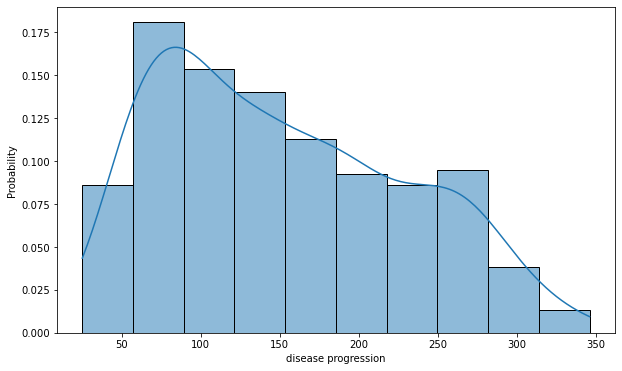

In [7]:
plt.figure(figsize = (10 , 6))
sns.histplot(data = diabetes["disease progression"] , kde = True , stat = "probability")

<br>
The distribution is right skewed.

### 3 DATA CLEANING

Before the prediction, we need to be sure there are not missing values, if some of them are missing we can proceed in two ways:
- delete the rows with missing values
- try to fill the empty cells  

The first method is of course the easiest, but deleting all the rows we also delete precious informations regarding the other variables.
The second method can be applied finding the correct value from other sources, or using a trick, like filling the empty cells with the mean or the median. This last process can be done using only the data inside the training set, to avoid a worst performance due to data leakage.<br><br>

In [8]:
diabetes.isnull().sum()

age                            0
sex                            0
body mass index                0
avg blood pressure             0
t-cells                        0
low-density lipoproteins       0
high-density lipoproteins      0
thyroid stimulating hormone    0
lamotrigine                    0
blood sugar level              0
disease progression            0
dtype: int64

<br>Fortunately this dataset is entirely filled.

### 4 REQUIREMENTS

The linear regression model has quite strict requirements:
- linearity
- homoskedasticity
- independence of variables
- non correlated errors

The linearity and the independence of the variables can be checked before launching the prediction, all the other requirements must be checked later.

##### LINEARITY

<br>This step is pretty easy, it's sufficient to plot every feature against the target:<br><br>

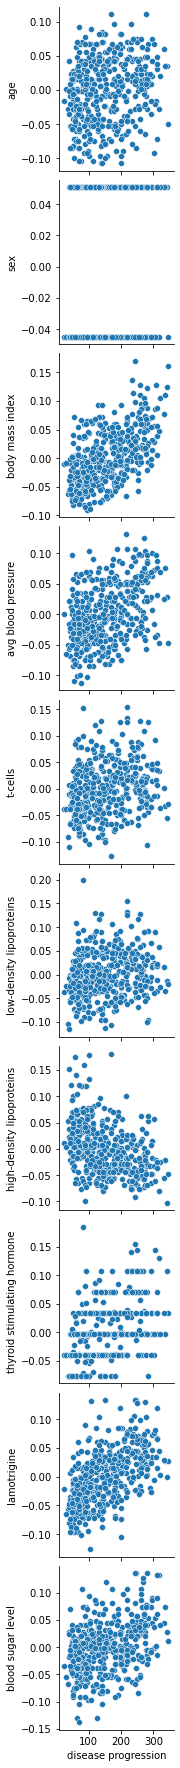

In [9]:
sns.pairplot(diabetes , x_vars = ["disease progression"] , y_vars = [f for f in diabetes if f != "disease progression"])

<br>
We can approximately say that the linearity is confirmed, anyway parameters of the real world are never perfectly linear. If many variables are non linear and this creates problems we can use a plynomial regression.

##### INDEPENDENCE OF VARIABLES

Multicollinearity is a huge problem in a statistical analysis, it happens when the variables are correlated to each other, this can lead to misinformation about the impact that a predictor variable has on the target, because that impact can derive from another factor.  

to check if there is multicollinearity in the dataset, the correlation matrix represents a good start.<br><br>

<AxesSubplot:>

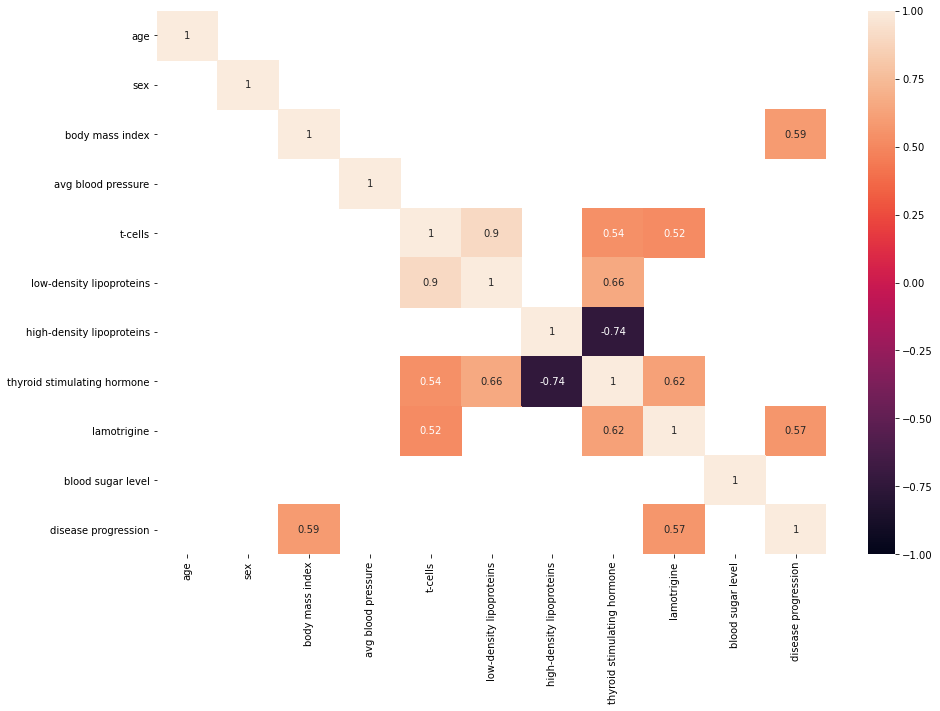

In [10]:
corr_matrix = diabetes.corr().round(2)

## not considering values between 0.5 and -0.5

def_corr = corr_matrix[(corr_matrix <= -0.5) | (corr_matrix >= 0.5)]

## correlation matrix plot

plt.figure(figsize = (15 , 10))
sns.heatmap(data = def_corr , vmin = -1 , vmax = 1 , annot = True)

<br>This matrix shows only the moderate correlations, correlation coefficients above 0.7 mean that there is a moderately high correlation.

From this graph we can obtain 3 informations: 

- low density lipoproteins and t-cells are higly correlated
- high density lipoproteins and thyroid stimulating hormone are moderately correlated
- none of the variables is higly correlated with the disease progression, so we'll need many variables to obtain an accurate model

    
To deal with collinearity it can also be used the vif (variance inflation factor), it works regressing every predictor against the others.  

a vif > 5 indicates a risk of collinearity, when this happens we can delete one of the correlated variables or create another variable that contains them.  

To use the vif method we need the coefficient of determination, which we can get using the linear regression model (this step is independent from the prediction part of this analysis):  


In [11]:
def vif_calculation(df , features):
    
    vif , tolerance = {} , {}
    
    for feature in features:
        
        ## list of all features to regress against
        
        X = [f for f in features if f != feature]
        
        ## dividing the feature and all the others
        
        X, y = df[X], df[feature]
        
        ## fitting the regression and extracting r-squared
        
        r2 = LinearRegression().fit(X , y).score(X , y)
        
        ## calculating vif
        
        tolerance[feature] = 1 - r2
        vif[feature] = 1/(tolerance[feature])
        
    return(pd.DataFrame({"vif" : vif}))

vif_calculation(df = diabetes , features = [column for column in  diabetes if column != "disease progression"])

,vif
age,1.217307
avg blood pressure,1.459429
blood sugar level,1.484623
body mass index,1.509446
high-density lipoproteins,15.402352
lamotrigine,10.076222
low-density lipoproteins,39.194379
sex,1.278073
t-cells,59.203786
thyroid stimulating hormone,8.890986


<br>Let's see what happens without "t-cells" variable:<br><br>

In [12]:
vif_calculation(df = diabetes , features = [column for column in  diabetes if column != "disease progression" and column != "t-cells"])

,vif
age,1.216892
avg blood pressure,1.457415
blood sugar level,1.484410
body mass index,1.502327
high-density lipoproteins,3.736893
lamotrigine,2.172865
low-density lipoproteins,2.926545
sex,1.275050
thyroid stimulating hormone,7.818675


<br>Let's also drop "thyroid stimulating hormone":<br><br>

In [13]:
drop_list = ["t-cells" , "thyroid stimulating hormone"]
vif_calculation(df = diabetes , features = [column for column in  diabetes if column != "disease progression" and column not in drop_list])

,vif
age,1.216284
avg blood pressure,1.447360
blood sugar level,1.476913
body mass index,1.498566
high-density lipoproteins,1.473826
lamotrigine,1.641089
low-density lipoproteins,1.180835
sex,1.269208


In [14]:
for feature in drop_list:
    diabetes.drop(columns = [feature] , inplace = True)

<br>The problem of multicollinearity is solved.<br><br>

### 5 MULTIPLE REGRESSION

##### MODEL TRAINING AND TESTING

<br>We can start resampling the dataset and dividing it into train and test:<br><br>

In [15]:
## features

X = diabetes.drop(columns = ["disease progression"])

## target

y = diabetes["disease progression"]

## shuffling and splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [16]:
## fitting and predicting

model = LinearRegression()
model.fit(X_train , y_train)
prediction = model.predict(X_test)

In [17]:
## coefficients and intercept

print("coefficients: %s" % model.coef_.round(2))
print("intercept: %f" % model.intercept_.round(2))

coefficients: [  35.5  -232.45  577.19  398.57 -126.91 -338.84  373.84  -18.11]
intercept: 150.330000


<br>Let's have a visual comparison between real and predicted data:<br><br>

     Actual  Predicted
287   219.0      142.2
211    70.0      187.8
72    202.0      140.2
321   230.0      282.8
73    111.0      120.2
..      ...        ...
346   139.0      175.8
168   268.0      207.2
393    69.0       97.3
141   317.0      202.9
324   249.0      198.8

[146 rows x 2 columns]


[Text(0.5, 1.0, 'PREDICTED VS. ACTUAL')]

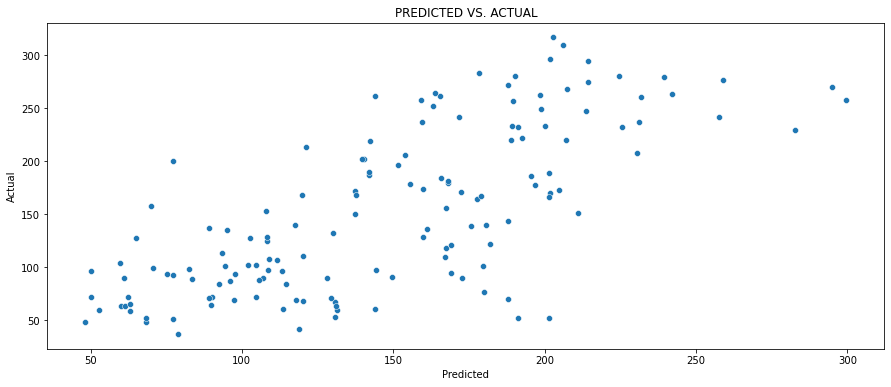

In [18]:
## DataFrame with real and predicted values

df_preds = pd.DataFrame({"Actual": y_test , "Predicted": prediction.round(1)})
print(df_preds)

## plot

plt.figure(figsize = (15 , 6))
sns.scatterplot(data = df_preds , x = "Predicted" , y = "Actual").set(title = "PREDICTED VS. ACTUAL")

##### EVALUATING THE PERFORMANCE

<br>In a regression model we can't use an accuracy score to verify if the model is accurate or not, but we can evaluate the performance as an error, for example using the mean absolute error or the root mean squared error. The R squared is instead useful to understand the "strenght" of the regression<br><br>

In [19]:
print("MAE = %f" % mean_absolute_error(y_test , prediction))
print("RMSE = %f" % np.sqrt(mean_squared_error(y_test , prediction)))
print("R-squared: %f" % r2_score(y_test , prediction).round(2))

MAE = 42.374167
RMSE = 53.434723
R-squared: 0.500000


<br>The model performance is not good. We can delete some of the variables and see if the model acts better. The feature selection can be done using the mutual information method:<br><br>

Text(0.5, 1.0, 'FEATURE IMPORTANCE WITH MUTUAL INFORMATION')

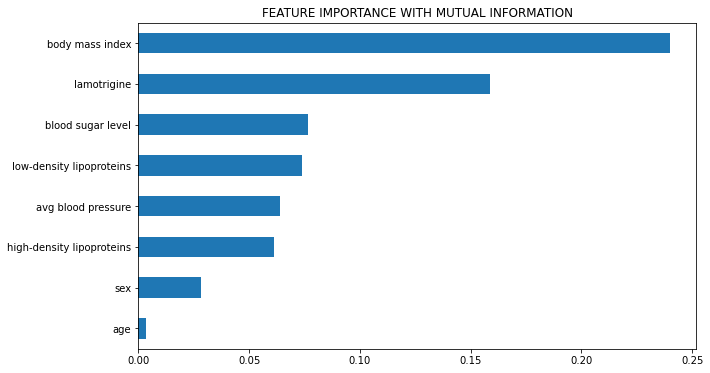

In [20]:
## mutual information

fs = SelectKBest(score_func = mutual_info_regression , k = 'all')

# learning relationship from training data

fs.fit(X_train, y_train)

## converting to series

mutual_info = pd.Series(fs.scores_)

## assigning column names

mutual_info.index = X_train.columns

## horizontal barplot in descending order

mutual_info.sort_values().plot.barh(figsize = (10, 6)).set_title("FEATURE IMPORTANCE WITH MUTUAL INFORMATION")


<br>This bar plot estimates the importance of every feature.<br><br>

In [21]:
diabetes_definitive = diabetes.drop(diabetes.columns[[0 , 1 , 3 , 5]] , axis = 1)
diabetes_definitive.head()

,body mass index,low-density lipoproteins,lamotrigine,blood sugar level,disease progression
0,0.061696,-0.034821,0.019908,-0.017646,151.0
1,-0.051474,-0.019163,-0.068330,-0.092204,75.0
2,0.044451,-0.034194,0.002864,-0.025930,141.0
3,-0.011595,0.024991,0.022692,-0.009362,206.0
4,-0.036385,0.015596,-0.031991,-0.046641,135.0


<br>Let's see how the model performs with only these four features:<br><br>

In [22]:
## splitting

X = diabetes_definitive.drop(columns = ["disease progression"])
y = diabetes_definitive["disease progression"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

## fitting and predicting

model.fit(X_train , y_train)
prediction = model.predict(X_test)

## evaluating performance

print("MAE = %f" % mean_absolute_error(y_test , prediction))
print("RMSE = %f" % np.sqrt(mean_squared_error(y_test , prediction)))
print("R-squared = %f" % r2_score(y_test , prediction).round(2))


MAE = 42.988914
RMSE = 53.177241
R-squared = 0.510000


<br>Despite the feature selection, the model accuracy data are not encouraging. 

### 6 LAST REQUIREMENTS

<br>Let's check if the requirements of homoskedasticity and non correlated errors are observed.<br><br>

[Text(0.5, 1.0, 'RESIDUALS DISTRIBUTION')]

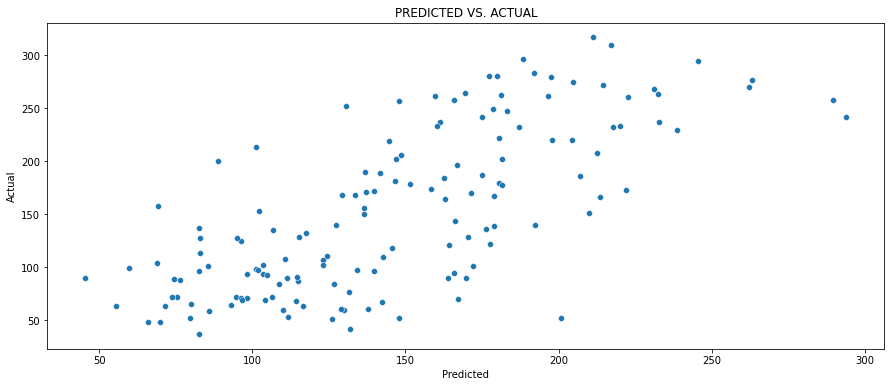

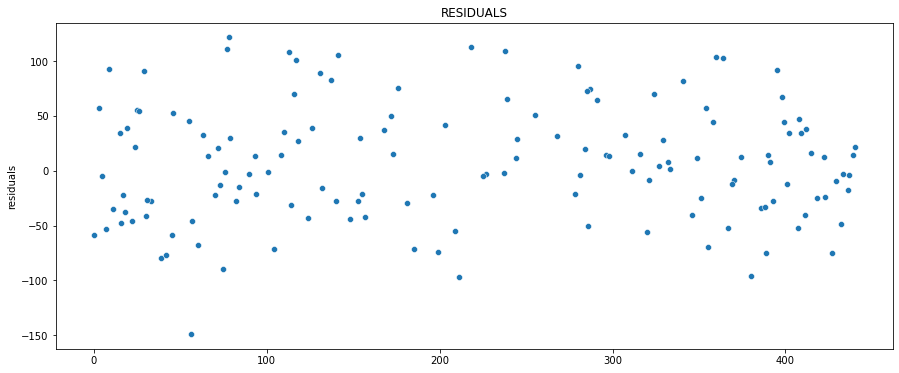

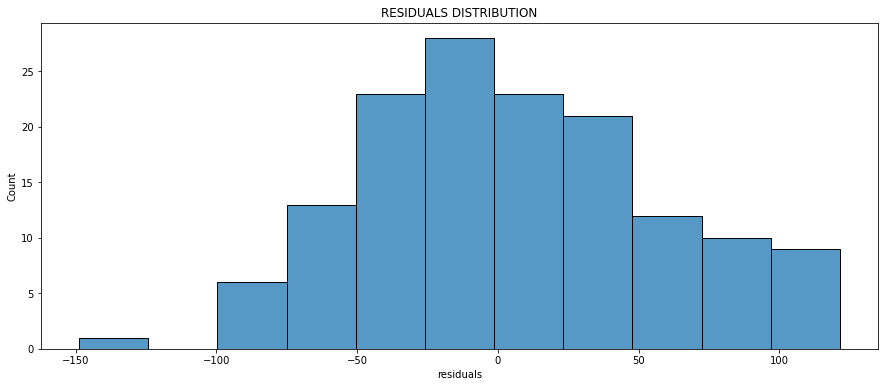

In [23]:
df_preds = pd.DataFrame({'Actual': y_test , 'Predicted': prediction})
df_preds["residuals"] = df_preds["Actual"] - df_preds["Predicted"]

## predicted vs actual

plt.figure(figsize = (15 , 6))
sns.scatterplot(data = df_preds , x = "Predicted" , y = "Actual").set(title = "PREDICTED VS. ACTUAL")

## residuals

plt.figure(figsize = (15 , 6))
sns.scatterplot(data = df_preds["residuals"]).set(title = "RESIDUALS")

plt.figure(figsize = (15 , 6))
sns.histplot(data = df_preds["residuals"]).set(title = "RESIDUALS DISTRIBUTION")

<br>By looking at the graphs, we can say that the residuals distribution is roughly normal, furthermore the distance between actual and predicted values is the same along the regression line, so homoskedasticity and non correlation of errors are confirmed.

<br>Returning to the performance analysis, we can try to regulirize the model using ridge and lasso and hope for an improvement.

### 7 RIDGE REGRESSION

In [24]:
## range with step of 0.1

alphas = np.arange(0.1 , 20 , 0.1)

## ridge model with built in validation

model_ridge = RidgeCV(alphas = alphas).fit(X_train , y_train)
prediction = model_ridge.predict(X_test)

## returning the minimum rmse

print("BEST MAE: %f" % mean_absolute_error(y_test , prediction).min().round(2))
print("R-squared = %f" % r2_score(y_test , prediction).round(2))


BEST MAE: 43.570000
R-squared = 0.510000


### 8 LASSO REGRESSION

In [25]:
alphas = np.arange(0.0005 , 1 , 0.0005)
model_lasso = LassoCV(alphas = alphas).fit(X_train, y_train)
prediction = model_lasso.predict(X_test)

print("BEST MAE: %f" % mean_absolute_error(y_test , prediction).min().round(2))
print("R-squared = %f" % r2_score(y_test , prediction).round(2))


BEST MAE: 42.990000
R-squared = 0.510000


<br>
Ridge and Lasso perform slightly better than the non regulirized model, but the performance remains weak.  

### CONCLUSION

It seems that the linear regression model can be applied to this problem, in fact all the requirements are roughly respected, but the model predictions would be too different from reality, making it useless.
<br>